# Risque de cancer du col de l'utérus

>> **Vous trouvez les données et leur description :**<br>
>> https://www.kaggle.com/datasets/loveall/cervical-cancer-risk-classification<br>


In [1]:
import numpy as np, pandas as pd, seaborn as sns  
from datetime import datetime as dt
import os, warnings, time
from matplotlib import pyplot as plt

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")
seed = 123456789

# Librairies du projet

In [2]:
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import NuSVC, SVC, OneClassSVM
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import ConstantKernel, RBF, RationalQuadratic, ExpSineSquared, DotProduct, Matern, WhiteKernel

from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB, ComplementNB
# from lightgbm import LGBMClassifier
# from xgboost  import XGBClassifier
from sklearn.metrics import roc_curve, auc

from sklearn.metrics  import make_scorer, confusion_matrix, roc_curve, auc, accuracy_score, log_loss, hamming_loss, \
                             precision_score, recall_score, f1_score, jaccard_score,  \
                             precision_recall_curve, average_precision_score

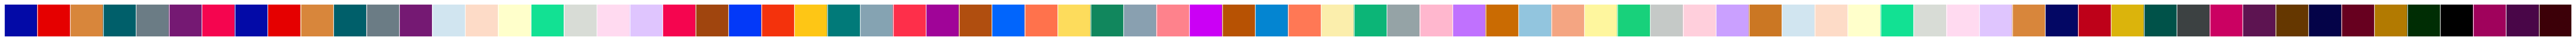

In [3]:
palette = [ "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973",
            "#f5054f", 
            "#030aa7", "#e50000", "#d8863b", "#005f6a", "#6b7c85", "#751973", "#d1e5f0", "#fddbc7",
            "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#f5054f", "#a0450e",
            "#0339f8", "#f4320c", "#fec615", "#017a79", "#85a3b2", "#fe2f4a", "#a00498", "#b04e0f",
            "#0165fc", "#ff724c", "#fddc5c", "#11875d", "#89a0b0", "#fe828c", "#cb00f5", "#b75203",
            "#0485d1", "#ff7855", "#fbeeac", "#0cb577", "#95a3a6", "#ffb7ce", "#c071fe", "#ca6b02",
            "#92c5de", "#f4a582", "#fef69e", "#18d17b", "#c5c9c7", "#ffcfdc", "#caa0ff", "#cb7723",
            "#d1e5f0", "#fddbc7", "#ffffcb", "#12e193", "#d8dcd6", "#ffdaf0", "#dfc5fe", "#d8863b",
            "#030764", "#be0119", "#dbb40c", "#005249", "#3c4142", "#cb0162", "#5d1451", "#653700",
            "#040348", "#67001f", "#b27a01", "#002d04", "#000000", "#a0025c", "#490648", "#3c0008"
          ]

paletteA = ['#b2182b','#008827','#053061','#ffa500', '#34495e', '#e74c3c', 
          '#9b59b6', '#0165fc','#2ecc71', '#cb7723', '#89a0b0']

sns.palplot(sns.color_palette(palette))

In [4]:
repertoireRacine  = '.'
nomProjet         = "Cancer du col de l'utérus"

repertoireProjet  = os.path.join(repertoireRacine, nomProjet)
repertoireDonnees = os.path.join(repertoireProjet, 'repertoire.donnees')
repertoireImages  = os.path.join(repertoireProjet, 'repertoire.images')


def controleExistenceRepertoire( repertoire, create_if_needed=True):
    """Voir si le répertoire existe. S'il n'existe pas il est créé."""
    path_exists = os.path.exists(repertoire)
    if path_exists:
        if not os.path.isdir(repertoire):
            raise Exception("Trouvé le nom  "+repertoire +" mais c'est un fichier, pas un répertoire")
            # return False
        return True
    if create_if_needed:
        os.makedirs(repertoire)

def sauvegarderImage( fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    plt.savefig(os.path.join(repertoireImages,
                             fichier+f"--{dt.now().strftime('%Y_%m_%d_%H.%M.%S')}.png"), 
                             dpi=600, 
                             bbox_inches='tight')

def sauvegarderImageSNS( sns_plot, fichier):
    """Enregistrez la figure. Appelez la méthode juste avant plt.show ()."""
    controleExistenceRepertoire(repertoireImages)
    fig = sns_plot.get_figure()
    fig.savefig(os.path.join(repertoireImages,fichier+'.png'))
    
controleExistenceRepertoire(repertoireProjet);
controleExistenceRepertoire(repertoireDonnees);
controleExistenceRepertoire(repertoireImages);

def afficheDistribution(colonne, cible):
        plt.figure(figsize=(14,12))
        sns.distplot(colonne[
                           cible == 1],
                       color="steelblue")
        sns.distplot(colonne[
                           cible == 0],
                       color="red")
        axline((colonne.median(), 0), (colonne.median(), 1), linewidth=1, color='r', linestyle='--')
        sauvegarderImage("La distribution des colonnes")    
        plt.show()
        
def createColumnsQualitatives(donnees,col):
    valeurs = donnees[col].sort_values().unique()
    for i in valeurs : 
        nom = col+'_'+str(i)
        donnees[nom] = donnees[col].apply(lambda x : 1 if x==i else 0)
    donnees.drop(labels=col, axis=1, inplace=True)   

def replaceNa_0(colonne, donnees, atype):
    donnees.loc[donnees[colonne].isna(),colonne] = 0
    donnees[colonne] = donnees[colonne].astype(atype)    

# Lecture de l'échantillon initial


<img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/main/images/EchantillonInitial.png" width="800">

In [5]:
!pwd

'pwd' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


In [6]:
donnees = pd.read_csv('../donnees/Cervical Cancer Risk Classification/kag_risk_factors_cervical_cancer.csv',
                      na_values='?')
donnees.columns = list(map(lambda x: str(x).replace(':',' '),donnees.columns))
cible = 'Dx Cancer'
donnees.head()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs Time since first diagnosis,STDs Time since last diagnosis,Dx Cancer,Dx CIN,Dx HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
1,15,1.0,14.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
2,34,1.0,NaN,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0
3,52,5.0,16.0,4.0,1.0,37.0,37.0,1.0,3.0,0.0,...,NaN,NaN,1,0,1,0,0,0,0,0
4,46,3.0,21.0,4.0,0.0,0.0,0.0,1.0,15.0,0.0,...,NaN,NaN,0,0,0,0,0,0,0,0


# Les valeurs manquantes

In [7]:
donnees.isna().sum()

Age                                     0
Number of sexual partners              26
First sexual intercourse                7
Num of pregnancies                     56
Smokes                                 13
Smokes (years)                         13
Smokes (packs/year)                    13
Hormonal Contraceptives               108
Hormonal Contraceptives (years)       108
IUD                                   117
IUD (years)                           117
STDs                                  105
STDs (number)                         105
STDs condylomatosis                   105
STDs cervical condylomatosis          105
STDs vaginal condylomatosis           105
STDs vulvo-perineal condylomatosis    105
STDs syphilis                         105
STDs pelvic inflammatory disease      105
STDs genital herpes                   105
STDs molluscum contagiosum            105
STDs AIDS                             105
STDs HIV                              105
STDs Hepatitis B                  

In [8]:
donnees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           832 non-null    float64
 2   First sexual intercourse            851 non-null    float64
 3   Num of pregnancies                  802 non-null    float64
 4   Smokes                              845 non-null    float64
 5   Smokes (years)                      845 non-null    float64
 6   Smokes (packs/year)                 845 non-null    float64
 7   Hormonal Contraceptives             750 non-null    float64
 8   Hormonal Contraceptives (years)     750 non-null    float64
 9   IUD                                 741 non-null    float64
 10  IUD (years)                         741 non-null    float64
 11  STDs                                753 non-n

In [9]:
for col in donnees.columns:
    print(col,'\n\t',donnees[col].sort_values().unique())

Age 
	 [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 59 70 79 84]
Number of sexual partners 
	 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 15. 28. nan]
First sexual intercourse 
	 [10. 11. 12. 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27.
 28. 29. 32. nan]
Num of pregnancies 
	 [ 0.  1.  2.  3.  4.  5.  6.  7.  8. 10. 11. nan]
Smokes 
	 [ 0.  1. nan]
Smokes (years) 
	 [ 0.          0.16        0.5         1.          1.26697291  2.
  3.          4.          5.          6.          7.          8.
  9.         10.         11.         12.         13.         14.
 15.         16.         18.         19.         20.         21.
 22.         24.         28.         32.         34.         37.
         nan]
Smokes (packs/year) 
	 [0.00000000e+00 1.00000000e-03 3.00000000e-03 2.50000000e-02
 4.00000000e-02 5.00000000e-02 1.00000000e-01 1.50000000e-01
 1.60000000e-01 2.00000000e-01 2.50000000e-01 3.00000000e-

## Remplacement des valeurs manquantes par 0

In [10]:
for colonne in ['Number of sexual partners', 
                'First sexual intercourse',
                'Num of pregnancies', 
                'Smokes', 
                'Hormonal Contraceptives',
                'IUD',
                'STDs', 
                'STDs (number)', 
                'STDs condylomatosis',
                'STDs cervical condylomatosis', 
                'STDs vaginal condylomatosis',
                'STDs vulvo-perineal condylomatosis', 
                'STDs syphilis',
                'STDs pelvic inflammatory disease', 
                'STDs genital herpes',
                'STDs molluscum contagiosum', 
                'STDs AIDS', 
                'STDs HIV',
                'STDs Hepatitis B', 
                'STDs HPV', 
                'STDs  Time since first diagnosis', 
                'STDs  Time since last diagnosis']: replaceNa_0(colonne, donnees,'int16')
    

for colonne in ['Smokes (years)','Smokes (packs/year)','Hormonal Contraceptives (years)','IUD (years)']: replaceNa_0(colonne, donnees, 'float32')

In [11]:
donnees.isna().sum()
donnees.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 858 entries, 0 to 857
Data columns (total 36 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Age                                 858 non-null    int64  
 1   Number of sexual partners           858 non-null    int16  
 2   First sexual intercourse            858 non-null    int16  
 3   Num of pregnancies                  858 non-null    int16  
 4   Smokes                              858 non-null    int16  
 5   Smokes (years)                      858 non-null    float32
 6   Smokes (packs/year)                 858 non-null    float32
 7   Hormonal Contraceptives             858 non-null    int16  
 8   Hormonal Contraceptives (years)     858 non-null    float32
 9   IUD                                 858 non-null    int16  
 10  IUD (years)                         858 non-null    float32
 11  STDs                                858 non-n

In [12]:
donnees.describe()

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs Time since first diagnosis,STDs Time since last diagnosis,Dx Cancer,Dx CIN,Dx HPV,Dx,Hinselmann,Schiller,Citology,Biopsy
count,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,...,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000,858.000000
mean,26.820513,2.451049,16.856643,2.127040,0.143357,1.201241,0.446278,0.560606,1.972394,0.096737,...,0.508159,0.481352,0.020979,0.010490,0.020979,0.027972,0.040793,0.086247,0.051282,0.064103
std,8.497948,1.698528,3.183491,1.508108,0.350641,4.060637,2.210361,0.496603,3.597885,0.295771,...,2.388333,2.297125,0.143398,0.101939,0.143398,0.164989,0.197925,0.280892,0.220701,0.245078
min,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,1.000000,15.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,25.000000,2.000000,17.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,32.000000,3.000000,18.000000,3.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,84.000000,28.000000,32.000000,11.000000,1.000000,37.000000,37.000000,1.000000,30.000000,1.000000,...,22.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
for col in donnees.columns:
    print(col,'\n\t',donnees[col].sort_values().unique())

Age 
	 [13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36
 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 59 70 79 84]
Number of sexual partners 
	 [ 0  1  2  3  4  5  6  7  8  9 10 15 28]
First sexual intercourse 
	 [ 0 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 32]
Num of pregnancies 
	 [ 0  1  2  3  4  5  6  7  8 10 11]
Smokes 
	 [0 1]
Smokes (years) 
	 [ 0.         0.16       0.5        1.         1.2669729  2.
  3.         4.         5.         6.         7.         8.
  9.        10.        11.        12.        13.        14.
 15.        16.        18.        19.        20.        21.
 22.        24.        28.        32.        34.        37.       ]
Smokes (packs/year) 
	 [0.0000000e+00 1.0000000e-03 3.0000000e-03 2.5000000e-02 3.9999999e-02
 5.0000001e-02 1.0000000e-01 1.5000001e-01 1.6000000e-01 2.0000000e-01
 2.5000000e-01 3.0000001e-01 3.1999999e-01 3.7000000e-01 4.0000001e-01
 4.4999999e-01 5.0000000e-01 5.1320213e-01 6.9999999e-01 

In [14]:
donnees.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs condylomatosis',
       'STDs cervical condylomatosis', 'STDs vaginal condylomatosis',
       'STDs vulvo-perineal condylomatosis', 'STDs syphilis',
       'STDs pelvic inflammatory disease', 'STDs genital herpes',
       'STDs molluscum contagiosum', 'STDs AIDS', 'STDs HIV',
       'STDs Hepatitis B', 'STDs HPV', 'STDs  Number of diagnosis',
       'STDs  Time since first diagnosis', 'STDs  Time since last diagnosis',
       'Dx Cancer', 'Dx CIN', 'Dx HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

# La separation des données pour l'apprentissage

<img src="https://raw.githubusercontent.com/rbizoi/IntelligenceEnDonneesDeSante/main/images/EchantillonApprentissageTest.png" width="800">

In [15]:
X = donnees.drop(columns=cible)
y = donnees[cible]
X_train, X_test, y_train, y_test = train_test_split( X, 
                                                     y, 
                                                     test_size=0.2, 
                                                     random_state=0, 
                                                     stratify = y
                                                   ) 

In [16]:
X_train.shape, X_test.shape

((686, 35), (172, 35))

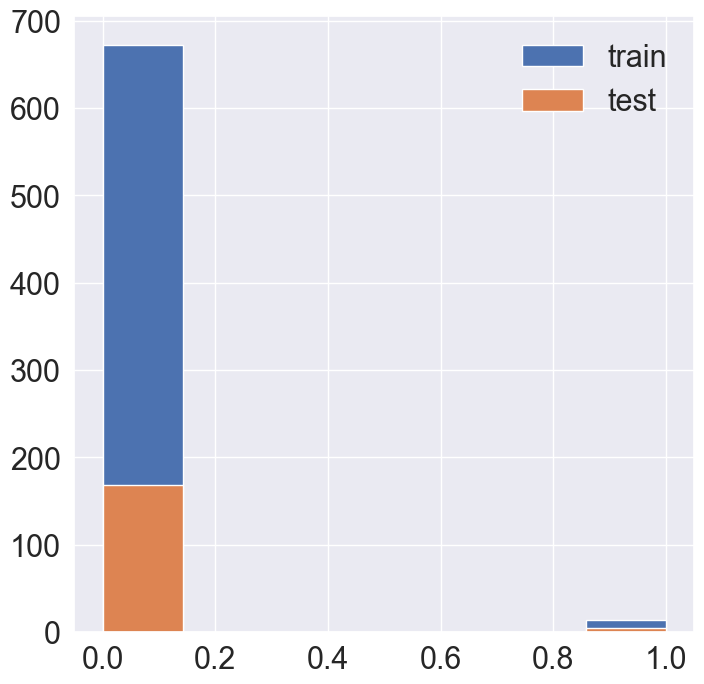

In [17]:
y_train.hist(bins=7, figsize=(8,8), label='train');
y_test.hist(bins=7, figsize=(8,8), label='test');
plt.legend();
sauvegarderImage("La separation des données pour l'apprentissage")

# Le déclaration des classifieurs 

In [28]:
names = [
            'Random_Forest',
            'AdaBoost',
            'LogisticRegression',
            'Nearest_Neighbors',
            # 'GaussianNaiveBayes',
            'Neural_Net'
        ]

classifiers = [
            RandomForestClassifier(
                max_depth=6,
                max_features=3,
                min_samples_split=4,
                n_estimators=32,
                n_jobs=-1
            ),
            AdaBoostClassifier(n_estimators=32),    
            LogisticRegression(
                C=0.81113,
                max_iter=8000,
                penalty='l2',
                solver='lbfgs',
                n_jobs=-1
            ),
            KNeighborsClassifier(
                algorithm='ball_tree',
                n_neighbors=32,
                p=1,
                weights='distance',
                n_jobs=-1
            ),
            # GaussianNB(),
            MLPClassifier(alpha=1),
        ]

dictModels = {name:clf for name, clf in zip(names, classifiers)}

In [24]:
dictModels

{'Random_Forest': RandomForestClassifier(max_depth=6, max_features=3, min_samples_split=4,
                        n_estimators=12, n_jobs=-1),
 'AdaBoost': AdaBoostClassifier(n_estimators=12),
 'LogisticRegression': LogisticRegression(C=0.81113, max_iter=8000, n_jobs=-1),
 'Nearest_Neighbors': KNeighborsClassifier(algorithm='ball_tree', n_jobs=-1, n_neighbors=32, p=1,
                      weights='distance'),
 'Neural_Net': MLPClassifier(alpha=1)}

# Le choix des classifieurs 

In [25]:
def choixClassifieurs(X_train, y_train,X_test, y_test, dictModels):
    np.random.seed(123456)
    t0 = time.time()  
    # h = .02  # step size in the mesh
    lw = 1

    plt.figure(figsize=(18,36))
    if int(str(sns.__version__).split('.')[1]) > 8 : 
        plt.style.use('seaborn-v0_8-darkgrid')
    else:
        plt.style.use('seaborn-darkgrid')
    couleurs = sns.hls_palette(len(dictModels.keys()), l=.4, s=.9)
    r_acc,r_aucROC = dict(),dict()
    fauxPositifs, vraisPositifs, probabilites = dict(),dict(),dict()
    accuracy,logloss,hammingloss,precision,sensibilite,f1,jaccard = dict(),dict(),dict(),dict(),dict(),dict(),dict()
    prec, rec, tauxPR, avgPrecRec =  dict(),dict(),dict(),dict()

    for i, nom in enumerate(dictModels):    
        t1 = time.time()  
        dictModels[nom].fit(X_train, y_train)

        y_probas = dictModels[nom].predict_proba(X_test)
        y_pred = dictModels[nom].predict(X_test)
        fauxPositifs[nom], vraisPositifs[nom], probabilites[nom] = roc_curve(y_test.ravel(), y_probas[:, 1])

        r_aucROC[nom]     = auc(fauxPositifs[nom], vraisPositifs[nom])
        accuracy[nom]     = accuracy_score(y_test,y_pred)
        logloss[nom]      = log_loss(y_test,y_pred)
        hammingloss[nom]  = hamming_loss(y_test,y_pred)
        precision[nom]    = precision_score(y_test,y_pred)
        sensibilite[nom]  = recall_score(y_test,y_pred)
        f1[nom]           = f1_score(y_test,y_pred)
        jaccard[nom]      = jaccard_score(y_test,y_pred)


        prec[nom], rec[nom], tauxPR[nom] = precision_recall_curve(y_test.ravel(), y_probas[:, 1])
        avgPrecRec[nom] = average_precision_score(y_test.ravel(), y_probas[:, 1])

        print(f'{nom:21s}'+(' %.4f' % accuracy[nom]).lstrip('0'),end='\t--\t')
        print ("Area under the ROC curve : %0.4f" % r_aucROC[nom],end='\t--\t')
        print('Exécution  :'+('%.2fs' % (time.time() - t1)).lstrip('0'))

        plt.subplot(2, 1, 1)
        plt.plot(fauxPositifs[nom], vraisPositifs[nom], color=couleurs[i], label=nom + '(AUC = %0.4f)' % r_aucROC[nom])

        plt.subplot(2, 1, 2)
        plt.step(rec[nom], prec[nom], where='post', color=couleurs[i], label=f"{nom}(AP = {avgPrecRec[nom]:0.8f})")#alpha=0.8, 
        plt.fill_between(rec[nom], prec[nom], step='post', alpha=0.05)



    plt.subplot(2, 1, 1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Le taux de faux Positifs-(1 - Spécificité) = VN / (FP + VN)',size=18)
    plt.ylabel('Le taux de vrais positifs-Sensibilité = VP / (VP + FN)',size=18)
    plt.title('La courbe ROC (Receiver Operating Caracteristic)',size=20)
    plt.legend(loc="lower right")    

    plt.subplot(2, 1, 2)
    f_scores = np.linspace(0.2, 0.9, num=7)
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

    # plt.subplot(2, 1, 2)                
    # plt.plot([0, 1], [0.5, 0.5], 'k--')
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Sensibilité(Rappel) = VP / (VP + FN)', size=18)
    plt.ylabel('Précision = VP / (VP + FP)', size=18)      
    plt.title('La courbe Précision-Rappel',size=20)
    plt.legend(loc="lower left")    

    sauvegarderImage("Les courbes ROC et Précision-Rappel")    
    plt.show()

    print('Exécution  :'+('%.2fs' % (time.time() - t0)).lstrip('0'))

    resultat = pd.DataFrame(pd.Series(r_aucROC), columns=["aucROC"])
    resultat['avgPrecRec']     = pd.Series(avgPrecRec   )
    resultat['accuracy']     = pd.Series(accuracy   )
    resultat['f1']           = pd.Series(f1         )
    resultat['precision']    = pd.Series(precision  )
    resultat['sensibilite']  = pd.Series(sensibilite)
    resultat['logloss']      = pd.Series(logloss    )
    resultat['hammingloss']  = pd.Series(hammingloss)
    resultat['jaccard']      = pd.Series(jaccard    )

    resultat.sort_values('f1',ascending=False, inplace=True)
    return resultat

Random_Forest         0.9884	--	Area under the ROC curve : 1.0000	--	Exécution  :.21s
AdaBoost              0.9884	--	Area under the ROC curve : 0.9970	--	Exécution  :.14s
LogisticRegression    0.9884	--	Area under the ROC curve : 1.0000	--	Exécution  :1.20s
Nearest_Neighbors     0.9767	--	Area under the ROC curve : 0.8430	--	Exécution  :.08s
Neural_Net            0.9826	--	Area under the ROC curve : 1.0000	--	Exécution  :.90s


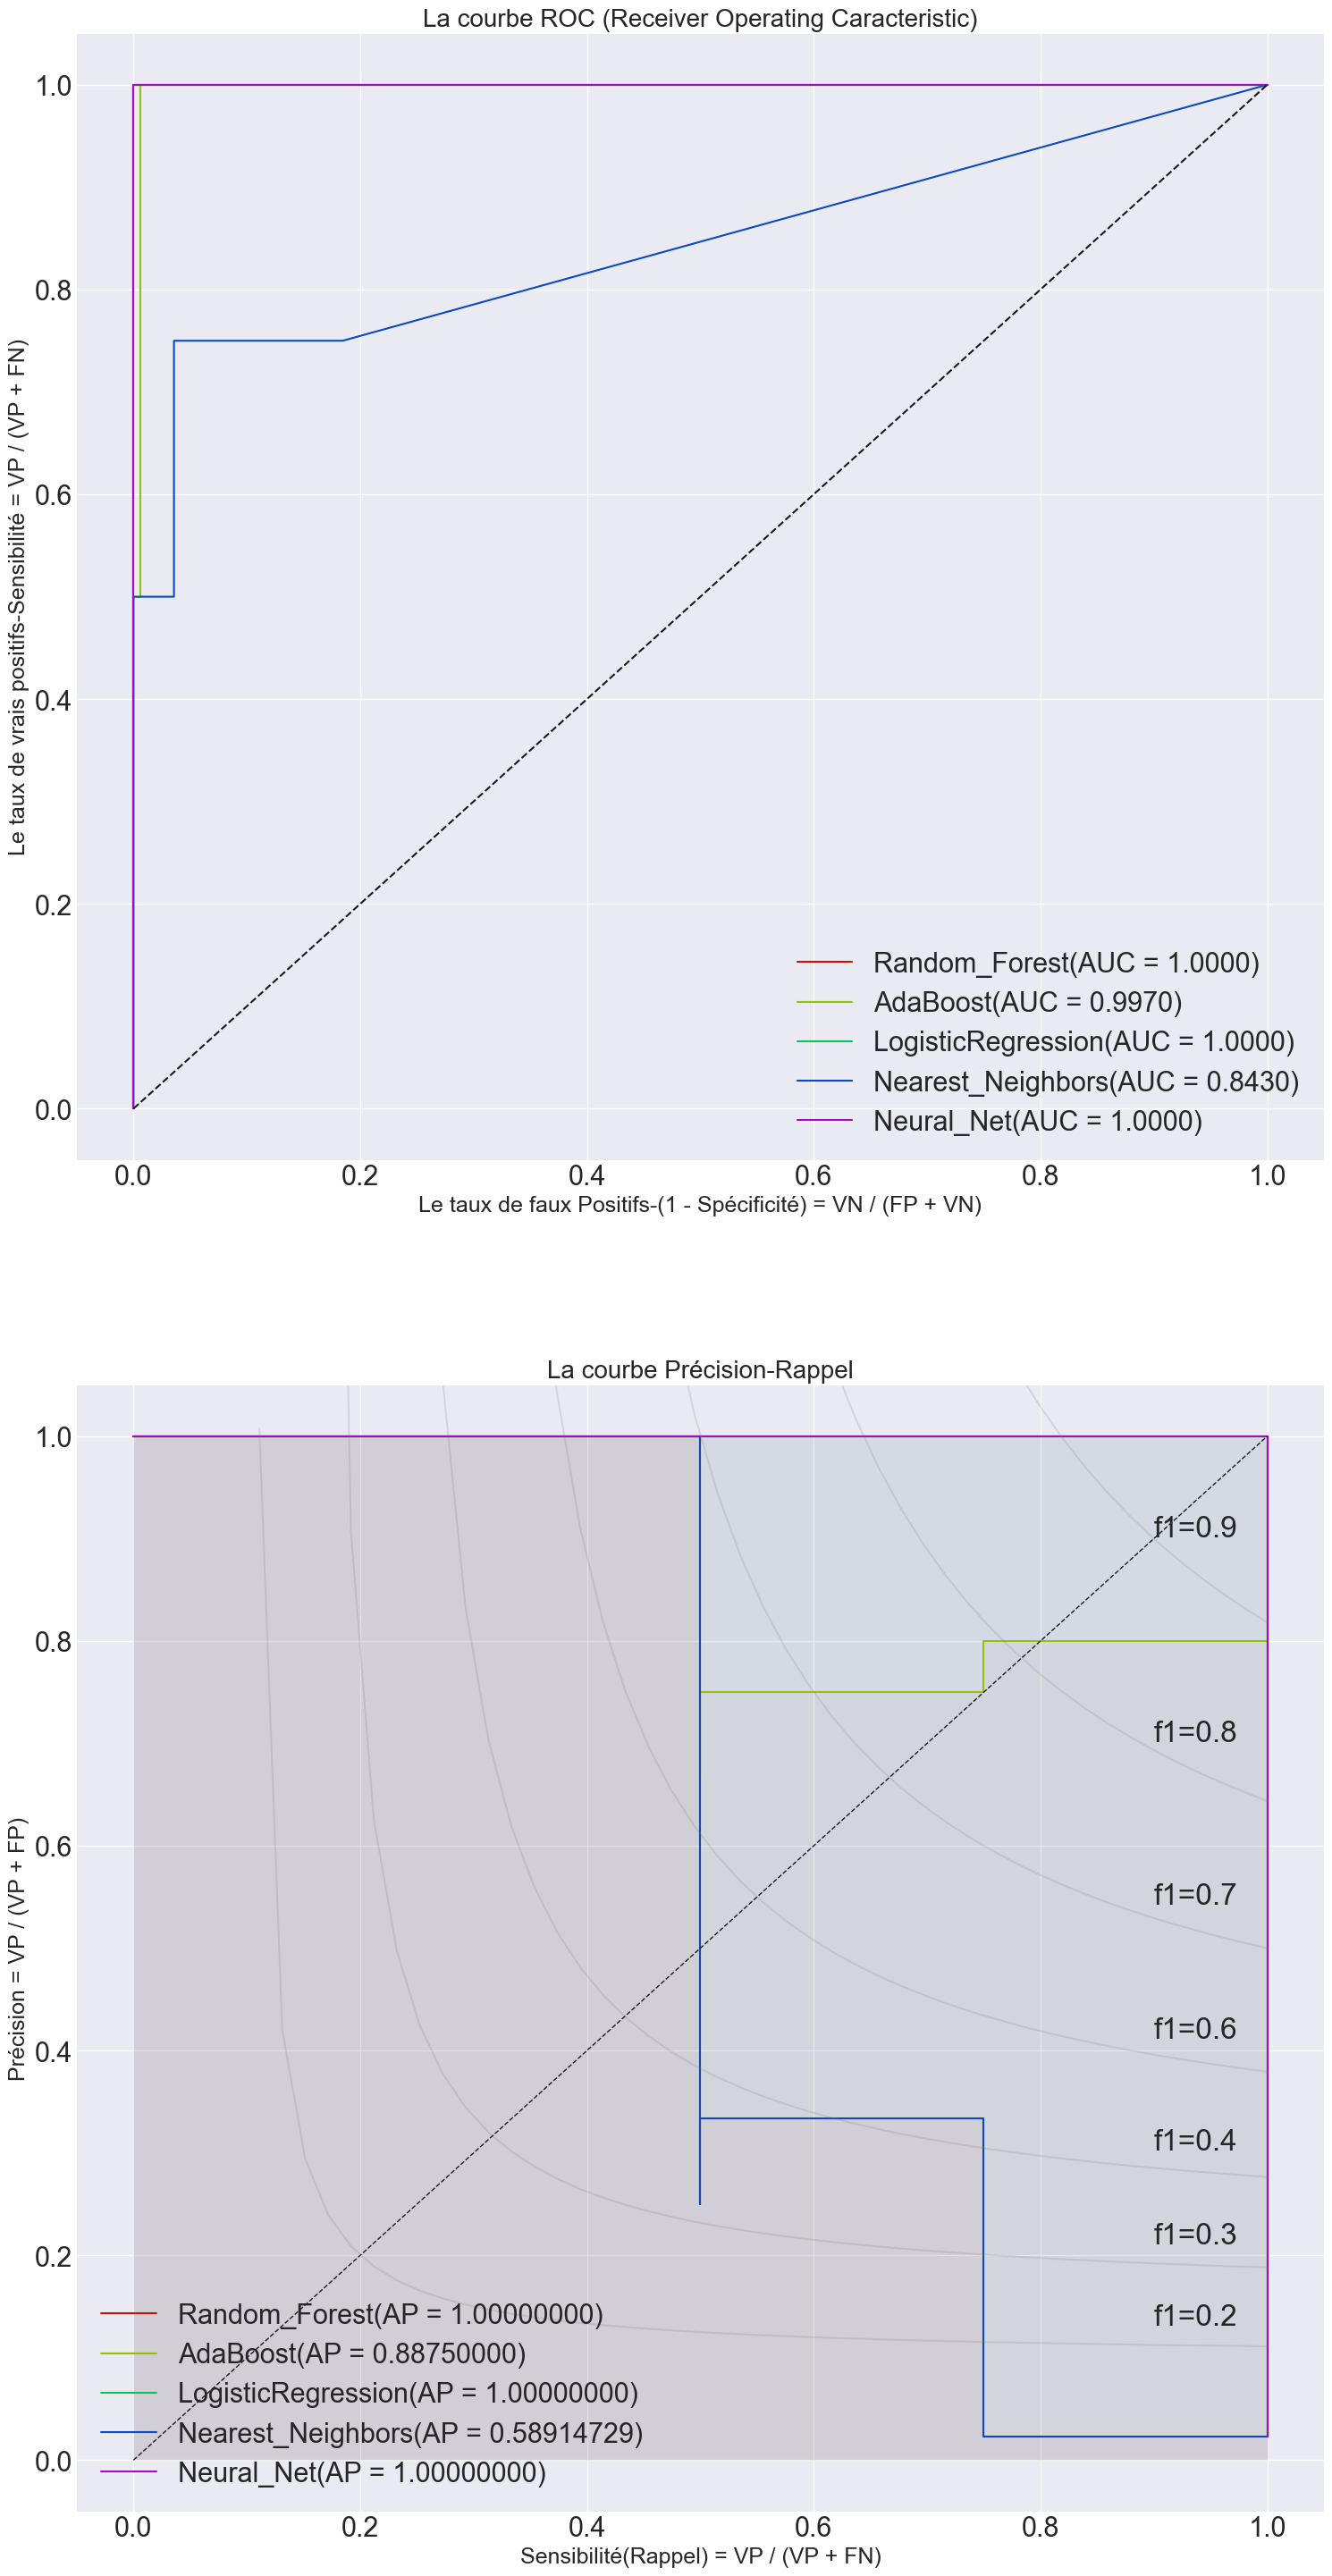

Exécution  :21.27s


In [29]:
resultatsBase = choixClassifieurs(X_train, y_train,X_test, y_test, dictModels)

In [30]:
resultatsBase['execution']='resultatsBase'
resultatsBase

,aucROC,avgPrecRec,accuracy,f1,precision,sensibilite,logloss,hammingloss,jaccard,execution
Random_Forest,1.000000,1.000000,0.988372,0.666667,1.0,0.50,0.419112,0.011628,0.50,resultatsBase
AdaBoost,0.997024,0.887500,0.988372,0.666667,1.0,0.50,0.419112,0.011628,0.50,resultatsBase
LogisticRegression,1.000000,1.000000,0.988372,0.666667,1.0,0.50,0.419112,0.011628,0.50,resultatsBase
Neural_Net,1.000000,1.000000,0.982558,0.400000,1.0,0.25,0.628668,0.017442,0.25,resultatsBase
Nearest_Neighbors,0.843006,0.589147,0.976744,0.000000,0.0,0.00,0.838224,0.023256,0.00,resultatsBase
